In [1]:
import itertools
import requests
import html5lib
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sps
import statsmodels.formula.api as sm
mpl.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline  

# Part I: Simulation

## Approximation of $\pi$ using Monte Carlo method
The goal is to approximate $\pi$ by randomly drawing points on the square $[0,1] \times [0,1]$ with a uniform distribution, and then counting the proportion of these points falling at a Euclidean distance smaller than 1 from the point $(0.0)$. This proportion must tend towards the area of the corresponding quarter of a circle, which corresponds to $\frac{\pi}{4}$. 

1. Write a function taking an integer *n* as input, performing the procedure described above by simulating *n* points and returning the resulting approximate value of $\pi$.

In [2]:
def pimontecarlo(n):
    X=np.random.random_sample((n,2))
    y=np.sum(np.sqrt(X[:,0]**2+X[:,1]**2)<1)
    return 4*y/n

In [3]:
pimontecarlo(int(1e6))

3.14082

2. Calculate approximate values of $\pi$ by applying your function to $n=10^k$ for $k \in \{2, 3, 4, 5, 6, 7\}$. Load these values in a container, then draw a figure comparing the approximations to the real value (as shown below).

In [4]:
k = range(2,8)
pi_approx = np.zeros((len(k)))
for i, p in enumerate(k):
    pi_approx[i] = pimontecarlo(10**p)

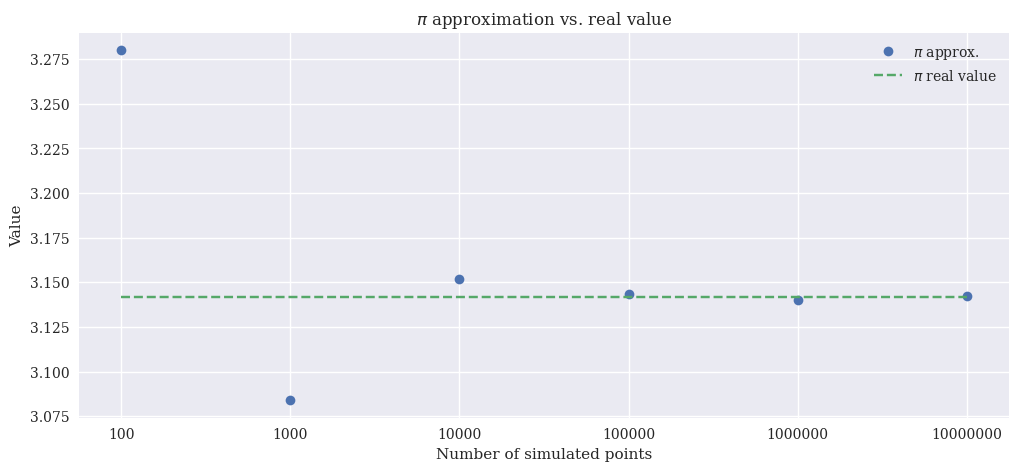

In [5]:
fig = plt.figure(figsize=(12,5))
plt.plot(k, pi_approx, 'o', label='$\pi$ approx.')
plt.plot(k, np.repeat(np.pi, len(k)), '--', label='$\pi$ real value')
plt.xticks(k, [str(10**i) for i in k])
plt.xlabel('Number of simulated points')
plt.ylabel('Value')
plt.title('$\pi$ approximation vs. real value')
plt.legend()
plt.show()

## Algorithm simulating Gaussian distribution
Here we are going to apply a classic method to generate i.i.d. standard normal random variables. Mathematically, it can be shown that if *R* follows exponential distribution of parameter 1\2, and if $\theta$ is uniformly distributed on the interval $[0, 2\pi]$, then the variables
$$
X = R \cos(\theta) \hspace{1cm} \text{ and  } \hspace{1cm} Y = R \sin(\theta)
$$
are independent and follow normal standard distribution.

3. Write a function taking an integer *n* as input, and returning *X* and *Y* containing *n* variables simulated according to the following algorithm: 
    * Generate $U1 \sim Uniform(0,1)$ and $U2 \sim Uniform(0,1)$ where $U1 \perp U2$
    * Simulate $R$ using inverse of the cumulative distribution method: $R=\sqrt{−2 \log(U1)}$
    * Set $\theta=2 \pi U2$
    * Set $X = R \cos(\theta)$ and $Y = R \sin(\theta)$

In [6]:
def box_muller(n):
    U1 = np.random.uniform(size=n)
    U2 = np.random.uniform(size=n)
    R = np.sqrt(-2 * np.log(U1))
    theta = 2 * np.pi * U2
    X = R * np.cos(theta)
    Y = R * np.sin(theta)
    return X, Y

4. Simulate *X* and *Y* *n*=$10^6$ times. Draw a figure with two horizontal subplots, displaying a histogram with simulated values of *X* compared to actual Gaussian density function on the left, and a histogram with simulated values of *Y* compared to the Gaussian density function on the right. *Hint*: set the attribute `density` to `True` to normalize the histogram and make it comparable to the density.

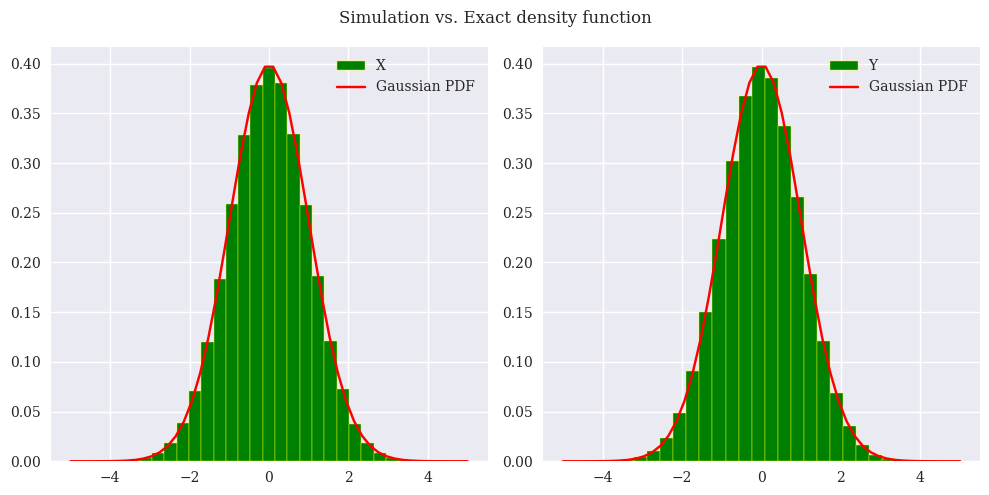

In [7]:
n = int(1e6)
X, Y = box_muller(n)
I=np.linspace(-5,5)
fig,axs = plt.subplots(1,2, figsize=(10,5))
axs[0].hist(X, density=True, bins=30, ec="yellow", fc="green", label='X')
axs[0].plot(I,sps.norm.pdf(I), color='r', label='Gaussian PDF')
axs[0].legend()
axs[1].hist(Y, density=True, bins=30, ec="yellow", fc="green", label='Y')
axs[1].plot(I,sps.norm.pdf(I), color='r', label='Gaussian PDF')
axs[1].legend()
plt.suptitle('Simulation vs. Exact density function')
plt.tight_layout()
plt.show()

# Part II: Data Scraping, Analysis & Visualisation 

## Scraping:
In this section you are going to scrape the parisian hotel listings from the wesite www.booking.com, focusing on such characteristics as price, location, etc., and then process and visualise certain aspects associated with this data.

1. Scrape [this](https://www.booking.com/searchresults.en-gb.html?label=gen173nr-1BCAEoggI46AdIM1gEaE2IAQGYAQm4AQfIAQ3YAQHoAQGIAgGoAgO4Ao-C-Z8GwAIB0gIkNmMzMTE5MmQtNGNjYS00MDY0LWE0NDctNzY3MGJlYmI5MGJj2AIF4AIB&sid=80b771ce0d7b41e0b337ca95ea8a21c8&aid=304142&ss=Paris%2C+Ile+de+France%2C+France&efdco=1&lang=en-gb&sb=1&src_elem=sb&src=index&dest_id=-1456928&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=fed67e8715dc00db&ac_meta=GhBmZWQ2N2U4NzE1ZGMwMGRiIAAoATICZW46BXBhcmlzQABKAFAA&checkin=2023-09-01&checkout=2023-09-03&group_adults=1&no_rooms=1&group_children=0&sb_travel_purpose=leisure&offset=0) page. Load the content into a BeautifulSoup object. Inspect the page, then extract all apartment listings.

In [29]:
### Check https://toolbox.googleapps.com/apps/browserinfo/ before scraping

URL_hotels = 'https://www.booking.com/searchresults.en-gb.html?label=gen173nr-1BCAEoggI46AdIM1gEaE2IAQGYAQm4AQfIAQ3YAQHoAQGIAgGoAgO4Ao-C-Z8GwAIB0gIkNmMzMTE5MmQtNGNjYS00MDY0LWE0NDctNzY3MGJlYmI5MGJj2AIF4AIB&sid=80b771ce0d7b41e0b337ca95ea8a21c8&aid=304142&ss=Paris%2C+Ile+de+France%2C+France&efdco=1&lang=en-gb&sb=1&src_elem=sb&src=index&dest_id=-1456928&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=fed67e8715dc00db&ac_meta=GhBmZWQ2N2U4NzE1ZGMwMGRiIAAoATICZW46BXBhcmlzQABKAFAA&checkin=2023-09-01&checkout=2023-09-03&group_adults=1&no_rooms=1&group_children=0&sb_travel_purpose=leisure&offset=0'
headers = requests.utils.default_headers()
headers.update({'User-Agent':
                'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36 OPR/95.0.0.0'})
#headers.update({'User-Agent':
#                'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'})
page_hotels = requests.get(URL_hotels, headers=headers)
soup_hotels = BeautifulSoup(page_hotels.content, "html5lib")


In [30]:
#print(soup_hotels.prettify())

In [31]:
paris_hotel_list = soup_hotels.find("div", class_="d4924c9e74")

In [32]:
#print(paris_hotel_list.prettify())

In [33]:
hotel_listings_0 = paris_hotel_list.find_all("div", {'data-testid' : 'property-card'})

In [34]:
len(hotel_listings_0)

26

2. How many hotel listings have you retrieved? Check the link to the second page. Find a way to modify the link in question 1 in order to access other pages, then write a program that loops over the listings' pages (say, first 20 pages), scrapes them, retrieves all the individual listings and stacks them in a list. You should get a list of about 600 hotel listings.

In [35]:
hotel_listings = []
hotel_listings.extend(hotel_listings_0)

In [36]:
for page in range(1, 20):
    print(page)
    URL_hotels = f'https://www.booking.com/searchresults.en-gb.html?label=gen173nr-1BCAEoggI46AdIM1gEaE2IAQGYAQm4AQfIAQ3YAQHoAQGIAgGoAgO4Ao-C-Z8GwAIB0gIkNmMzMTE5MmQtNGNjYS00MDY0LWE0NDctNzY3MGJlYmI5MGJj2AIF4AIB&sid=80b771ce0d7b41e0b337ca95ea8a21c8&aid=304142&ss=Paris%2C+Ile+de+France%2C+France&efdco=1&lang=en-gb&sb=1&src_elem=sb&src=index&dest_id=-1456928&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=fed67e8715dc00db&ac_meta=GhBmZWQ2N2U4NzE1ZGMwMGRiIAAoATICZW46BXBhcmlzQABKAFAA&checkin=2023-09-01&checkout=2023-09-03&group_adults=1&no_rooms=1&group_children=0&sb_travel_purpose=leisure&offset={30*page}'
    headers = requests.utils.default_headers()
    headers.update({'User-Agent':
                    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36 OPR/95.0.0.0'})
    #headers.update({'User-Agent':
    #                'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'})
    page_hotels = requests.get(URL_hotels, headers=headers)
    soup_hotels = BeautifulSoup(page_hotels.content, "html5lib")
    paris_hotel_list = soup_hotels.find("div", class_="d4924c9e74")
    hotel_listings_page = paris_hotel_list.find_all("div", {'data-testid' : 'property-card'})
    hotel_listings.extend(hotel_listings_page)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [37]:
len(hotel_listings)

501

## Extracting and saving information:

We will start with a couple of functions you will need to process the data scraped from the webpage.

3. Write a function `extract_first_number` that takes a string as input and extracts *all digits that appear before the first letter* in a form of an integer.

In [38]:
def extract_first_number(text):
    if text=='':
        return None
    is_not_digit_list = [not s.isdigit() for s in text]
    try:
        i = np.squeeze(np.argwhere(is_not_digit_list)[0]) # identifying the non-digits
    except IndexError: # appears if text is only digits
        return int(text)
    try:
        return int(text[:i])
    except ValueError: # appears if text is non-numerical
        return None

In [39]:
extract_first_number('3456')

3456

4. Write a function `extract_value_before_word` that takes a full string and its substring (word) as input and extracts *a sequence of digits that appears before the given word and after any preceding non-numeric characters* in a form of an integer. 

In [60]:
def extract_value_before_word(text, word):
    if text=='':
        return None
    word_pos = text.find(word)
    new_text=''
    pos = word_pos - 1
    flag = False
    while not flag:
        s = text[pos]
        if s.isdigit():
            new_text+=s
        elif s == ',': # condition to treat numbers with commas (thousands and up)
            pass
        else:
            flag = True
        pos -= 1
    value = new_text[::-1]
    try:
        return int(value)
    except ValueError: # necessary to address sequences without numbers and without word in them
        return None

5. Write a function `extract_distance` that takes a full string containing distance and units (m ou km, see examples) as input and extracts the value corresponding to the distance, returning in as a float in km.

In [41]:
def extract_distance(text):
    if text=='':
            return None
    else:
        km = text.find('km')
        m = text.find('m')
        if km != -1:
            return float(text[ : (km - 1)])
        elif m != -1:
            return float(text[ : (m - 1)]) / 1000

In [42]:
### Examples:
extract_distance('4.5 km from the center')

4.5

In [43]:
extract_distance('500 m from the center')

0.5

6. Go through all the extracted hotel listings and load in lists the following information (separate list for each information type, within every list maintain the same order as that in which listings appear on the webpage):
    * Names: load them as strings.
    * Links: also as strings.
    * Districts: use the function `extract_first_number` to extract them from the location strings and load them as floats.
    * Distances from the center: use the function `extract_distance` to load them as floats. 
    * Number of stars: integers from 0 to 5.
    * Ratings: load them as floats. 
    * Prices per night: use the function `extract_value_before_word` to load them in a numerical format. Take the discounted value if there is a discount. Pay attention to the fact that the prices on the page are given for two nights.
    * Free cancellation: True if present and False otherwise.
    * Breakfast included: True if present and False otherwise.
  

In [65]:
names = []
links = []
districts = []
distances = []
star_rating = []
ratings = []
prices = []
free_cancellation = []
breakfast_included = []
for i, listing_i in enumerate(hotel_listings):
    if i%50==0:
        print(i)
    name_el = listing_i.find("div", {'data-testid' : 'title'})
    name = name_el.text.strip()
    link_el = listing_i.find("a", {'data-testid' : 'title-link'})
    link = link_el['href']
    location_el = listing_i.find("span", {'data-testid' : 'address'})
    location_str = location_el.text.strip()
    district = extract_first_number(location_str)
    distance_el = listing_i.find("span", {'data-testid' : 'distance'})
    distance_str = distance_el.text.strip()
    distance = extract_distance(distance_str)
    stars_el = listing_i.find("div", {'aria-label' : lambda x: x and 'out of' in x})
    stars = int(stars_el['aria-label'][0]) if stars_el is not None else 0
    #rating_el = listing_i.find("div", {'data-testid' : 'review-score'})
    rating_el = listing_i.find("div", {'aria-label' : lambda x: x and 'Score' in x})
    rating = float(rating_el.text.strip()) if rating_el is not None else None
    price_el = listing_i.find("div", {'data-testid' : 'availability-rate-information'})
    price_str = price_el.text.strip()
    price_cte = extract_value_before_word(price_str, 'Price')
    price = price_cte if price_cte is not None else extract_value_before_word(price_str, 'Original price')
    price /= 2
    free_cancel = False if listing_i.text.strip().lower().find('free cancellation') == -1 else True
    breakfast = False if listing_i.text.strip().lower().find('breakfast included') == -1 else True
    
    names.append(name)
    links.append(link)
    districts.append(district)
    distances.append(distance)
    star_rating.append(stars)
    ratings.append(rating)
    prices.append(price)
    free_cancellation.append(free_cancel)
    breakfast_included.append(breakfast)

0
50
100
150
200
250
300
350
400
450
500


7. Create a hotel listings dictionary containing labels for previously mentioned characteristics as keys and the corresponding lists as values. Using Pandas.DataFrame, write the extracted information in an excel file, every row corresponding to one hotel listing, and every column to a certain characteristic.

In [68]:
hotel_listings_dict = {
    'Name' : names,
    'Link' : links,
    'District' : districts,
    'Distance' : distances,
    'Nb. stars' : star_rating,
    'Rating' : ratings,
    'Price per night (euro)' : prices,
    'Free cancellation' : free_cancellation,
    'Breakfast included' : breakfast_included
}

In [69]:
hotel_listings_df = pd.DataFrame(hotel_listings_dict)
hotel_listings_df.to_excel('hotel_listings.xlsx')

In [70]:
hotel_listings_df.head()

,Name,Link,District,Distance,Nb. stars,Rating,Price per night (euro),Free cancellation,Breakfast included
0,Hôtel La Sanguine,https://www.booking.com/hotel/fr/la-sanguine.e...,8.0,2.7,2,7.7,149.5,False,False
1,Hôtel Soft,https://www.booking.com/hotel/fr/soft.en-gb.ht...,10.0,1.9,3,7.7,192.5,False,False
2,UCPA SPORT STATION HOSTEL PARIS,https://www.booking.com/hotel/fr/ucpa-sport-st...,19.0,4.8,0,8.0,30.0,True,False
3,Hôtel Brésil Opéra,https://www.booking.com/hotel/fr/bresil-opera....,9.0,1.8,3,8.2,196.5,True,False
4,The People - Paris Bercy,https://www.booking.com/hotel/fr/the-people-ho...,12.0,3.6,0,8.8,78.0,True,False


## Paris districts & Prices per night

8. Make a plot with two horizontal subplots. Plot a pie chart showing proportions of hotel from every category with respect to the number of stars on the left, and a figure showing mean values of prices per night in each of these categories with standard deviation (you can use function `matplotlib.pyplot.errorbar`). Try to make it understandable: add axes labels, subplot titles, etc. Comment on any interesting trends that you may observe from the graphs.

In [13]:
#hotel_listings_df = pd.read_excel('hotel_listings.xlsx')

In [3]:
price_per_night = hotel_listings_df['Price per night (euro)']

In [4]:
nb_stars = hotel_listings_df['Nb. stars'].values
present_stars_ind = np.nonzero([np.any(nb_stars==i) for i in range(6)])[0]

In [5]:
pie_cats = np.zeros((len(present_stars_ind)))
for i in range(len(present_stars_ind)):
    pie_cats[i] = np.count_nonzero(nb_stars==present_stars_ind[i])/len(nb_stars)

In [6]:
price_per_night_means = np.zeros((len(present_stars_ind)))
price_per_night_std = np.zeros((len(present_stars_ind)))
for i in range(len(present_stars_ind)):
    price_per_night_means[i] = price_per_night[nb_stars==present_stars_ind[i]].mean()
    price_per_night_std[i] = price_per_night[nb_stars==present_stars_ind[i]].std()

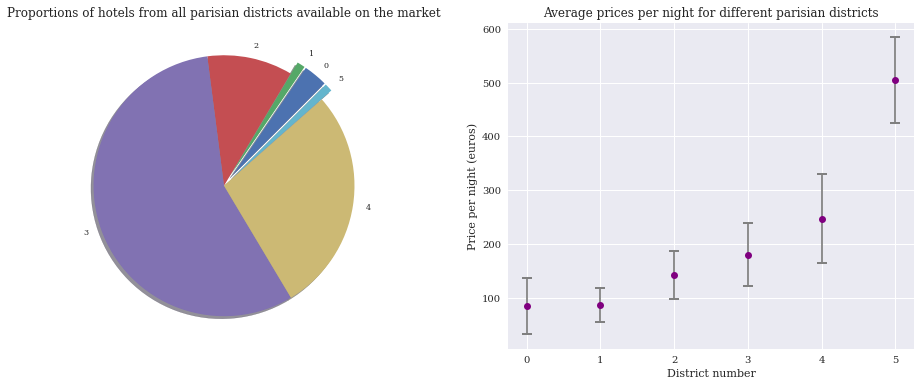

In [7]:
explode = np.zeros((len(present_stars_ind)))
explode[pie_cats<0.1] = 0.1
present_stars_str = (present_stars_ind).astype(str)
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].pie(pie_cats, labels=present_stars_str, shadow = True, normalize=True, explode = explode, startangle=45,
           textprops={'fontsize': 8})
axs[0].set_title('Proportions of hotels from all parisian districts available on the market')
axs[1].errorbar((present_stars_ind), price_per_night_means, price_per_night_std, fmt='none',
                linestyle='', ecolor='grey', capsize=5, capthick=2)
axs[1].plot((present_stars_ind), price_per_night_means, 'o', c='purple', markersize=7)
axs[1].set_xlabel('District number')
axs[1].set_ylabel('Price per night (euros)')
axs[1].set_xticks(present_stars_ind)
axs[1].set_xticklabels(present_stars_str)
axs[1].set_title('Average prices per night for different parisian districts')
plt.show()

## Outliers detection
9. Use the function `zscore` of the module `scipy.stats` in order to determine the outliers in the data with respect to prices per night. Calculate the z-score within every star category and identify the hotels with z-score larger than 3 (i.e. extraordinarily expensive hotels). Calculate the average rating for these hotels. How does it compare to the average rating of all hotels?

In [15]:
#hotel_listings_df = pd.read_excel('hotel_listings.xlsx')
#hotel_listings_df.head()

In [8]:
# Examination of outliers for every star category:
price_per_night_outliers = []
for i in present_stars_ind:
    print(i)
    hotel_indices_group_i = (nb_stars==i).nonzero()[0]
    price_per_night_group_i = price_per_night[hotel_indices_group_i].values
    price_per_night_zscore = sps.zscore(price_per_night_group_i)
    price_per_night_outliers.extend(hotel_indices_group_i[(price_per_night_zscore>3).nonzero()[0]])

0
1
2
3
4
5


In [9]:
outliers_rating = hotel_listings_df['Rating'].iloc[price_per_night_outliers]

In [10]:
hotel_listings_df['Rating'].mean()

8.079834710743802

In [93]:
# We get a much higher average rating for the outliers than for all hotels. 
# This could explain the extraordinarily high prices.
outliers_rating.mean()

8.583333333333334

## Regression

In [66]:
#hotel_listings_df = pd.read_excel('hotel_listings.xlsx')
#hotel_listings_df.head()

10. Using function `linregress` of module `scipy.stats` in order to calculate a linear least-squares regression predicting the prices (euro) based on the distance from center (km). Extract the slope and intercept, then plot the obtained regression fitted line along with the data points. Does linear model appear to represent well the dependency of prices on the distance form center? Then do the same within each star category, plot all regressions on one figure using subplots. Compare the obtained results.

In [67]:
x = hotel_listings_df['Distance']
y = hotel_listings_df['Price per night (euro)']
distance_to_price_reg = sps.linregress(x, y)
print(f"R-squared: {distance_to_price_reg.rvalue**2:.6f}")

R-squared: 0.064713


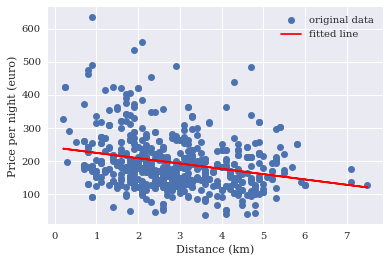

In [68]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, distance_to_price_reg.intercept + distance_to_price_reg.slope * x, 'r', label='fitted line')
plt.xlabel('Distance (km)')
plt.ylabel('Price per night (euro)')
plt.legend()
plt.show()

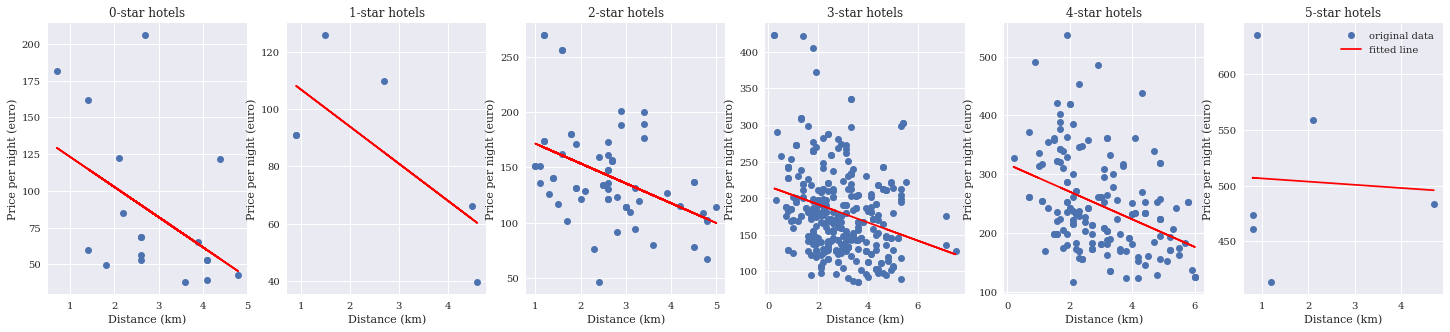

In [96]:
# The higher the star category, the less steep the regression slope. 
# 5-star hotel prices appear to be almost independent of the distance from the center, 
# the opposite is observed for hostels.
# However, we cannon make strong conslusions for some categories due to the lack of data and high variability.
fig, axs = plt.subplots(1, len(present_stars_ind), figsize=(25, 5))
for i in present_stars_ind:
    hotel_indices_group_i = (nb_stars==i).nonzero()[0]
    x_i = x[hotel_indices_group_i]
    y_i = y[hotel_indices_group_i]
    distance_to_price_reg_i = sps.linregress(x_i, y_i)
    axs[i].plot(x_i, y_i, 'o', label='original data')
    axs[i].plot(x_i, distance_to_price_reg_i.intercept + distance_to_price_reg_i.slope * x_i, 'r', label='fitted line')
    axs[i].set_xlabel('Distance (km)')
    axs[i].set_ylabel('Price per night (euro)')
    axs[i].set_title(f'{i}-star hotels')
plt.legend()
plt.show()

## Some statistical tests

11. Perform a Student's t-test in order to determine whether there is a significant difference in prices per night depending on the presence or the absence of the free cancellation option by applying the function `ttest_ind` from the module `scipy.stats`. Do the same for the breakfast included option and comment.

In [69]:
hotels_with_free_cancel = hotel_listings_df[hotel_listings_df['Free cancellation']]
hotels_without_free_cancel = hotel_listings_df[hotel_listings_df['Free cancellation']==False]
sps.ttest_ind(hotels_with_free_cancel[['Price per night (euro)']], 
              hotels_without_free_cancel[['Price per night (euro)']])

Ttest_indResult(statistic=array([3.22867486]), pvalue=array([0.00131119]))

In [70]:
hotels_with_breakfast = hotel_listings_df[hotel_listings_df['Breakfast included']]
hotels_without_breakfast = hotel_listings_df[hotel_listings_df['Breakfast included']==False]
sps.ttest_ind(hotels_with_breakfast[['Price per night (euro)']], 
              hotels_without_breakfast[['Price per night (euro)']])

Ttest_indResult(statistic=array([-2.87215008]), pvalue=array([0.00422022]))

In [75]:
hotels_without_free_cancel['Price per night (euro)'].mean()

188.2193763919822

12. Using a for loop over all parisian districts, perform a series of t-tests in order to determine whether there is a significant difference in prices per night between different districts. Print the obtained statisticts.

In [79]:
district_pairs = list(itertools.combinations(np.unique(hotel_listings_df['District']), 2))
small_p = 0
for p in district_pairs:
    print(f'Districts {p[0]} and {p[1]}')
    hotels_in_district_n1 = hotel_listings_df[hotel_listings_df['District']==p[0]]
    hotels_in_district_n2 = hotel_listings_df[hotel_listings_df['District']==p[1]]
    test = sps.ttest_ind(hotels_in_district_n1[['Price per night (euro)']], 
                         hotels_in_district_n2[['Price per night (euro)']])
    print(f't-statistic {round(test[0][0], 3)} with p-value {round(test[1][0], 3)}')
    if test[1][0]<0.01:
        small_p += 1
        print(f'Districts {p[0]} and {p[1]} have significantly different prices per night')

Districts 1.0 and 2.0
t-statistic 1.631 with p-value 0.114
Districts 1.0 and 3.0
t-statistic 0.27 with p-value 0.79
Districts 1.0 and 4.0
t-statistic 1.578 with p-value 0.128
Districts 1.0 and 5.0
t-statistic 4.927 with p-value 0.0
Districts 1.0 and 5.0 have significantly different prices per night
Districts 1.0 and 6.0
t-statistic 1.844 with p-value 0.071
Districts 1.0 and 7.0
t-statistic 1.346 with p-value 0.19
Districts 1.0 and 8.0
t-statistic 3.184 with p-value 0.002
Districts 1.0 and 8.0 have significantly different prices per night
Districts 1.0 and 9.0
t-statistic 4.803 with p-value 0.0
Districts 1.0 and 9.0 have significantly different prices per night
Districts 1.0 and 10.0
t-statistic 8.837 with p-value 0.0
Districts 1.0 and 10.0 have significantly different prices per night
Districts 1.0 and 11.0
t-statistic 5.086 with p-value 0.0
Districts 1.0 and 11.0 have significantly different prices per night
Districts 1.0 and 12.0
t-statistic 6.981 with p-value 0.0
Districts 1.0 and 1

t-statistic -1.436 with p-value 0.155
Districts 12.0 and 18.0
t-statistic 2.277 with p-value 0.026
Districts 12.0 and 19.0
t-statistic 3.545 with p-value 0.001
Districts 12.0 and 19.0 have significantly different prices per night
Districts 12.0 and 20.0
t-statistic 2.868 with p-value 0.007
Districts 12.0 and 20.0 have significantly different prices per night
Districts 12.0 and nan
t-statistic nan with p-value nan
Districts 13.0 and 14.0
t-statistic 0.006 with p-value 0.995
Districts 13.0 and 15.0
t-statistic -2.215 with p-value 0.03
Districts 13.0 and 16.0
t-statistic -1.651 with p-value 0.107
Districts 13.0 and 17.0
t-statistic -1.887 with p-value 0.063
Districts 13.0 and 18.0
t-statistic 0.972 with p-value 0.336
Districts 13.0 and 19.0
t-statistic 2.209 with p-value 0.034
Districts 13.0 and 20.0
t-statistic 1.929 with p-value 0.066
Districts 13.0 and nan
t-statistic nan with p-value nan
Districts 14.0 and 15.0
t-statistic -2.799 with p-value 0.006
Districts 14.0 and 15.0 have signifi